In [33]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter  # Import ScalarFormatter
import uproot
sys.path.append("../")
import saq
import glob
import  csv


In [34]:
#Use the function glob() in the glob libary to obtain a list of paths matching a pathname pattern
root_file_paths = sorted(glob.glob('/home/wwz/saq_analysis/calibration/11_09_2023_complete_calibration/*.root'))
#sorted(root_file_paths)
#print(sorted(root_file_paths))


# Initialize lists to store data for each file
timestamps_list = []
masks_list = []

# Define constants
clock_rate = 30.3e6
nn = 0
cutoff = (2**32) - 1
loop_time = cutoff / clock_rate

real_channel =[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

# Iterate through each root file
for j, root_file_path in enumerate(root_file_paths):
    # Open the ROOT file
    file = uproot.open(root_file_path)

    # Access the tree from the ROOT file
    tree = file["tt"]  # 'tt' is the name of the data tree in the root file

    # Convert the tree data into a dictionary
    data = tree.arrays(library="np")

    # Get timestamps from the data
    timestamps = data["Timestamp"]
    mask = data["ChMask"]
    pid = data['pid']
    #print(len(timestamps))
    #print(min(pid))
    print(pid[:10], min(pid))

    #print(timestamps[:10])
    #print(mask[:10])
    
    #filtered_timestamps =[]
    #for i in range(len(timestamps)):
        #if mask[i] == 2**(ch-1):
            #filtered_timestamps.append(timestamps[i]
    
    #This line does the same thing as the loop above, but in a more consice and Pythonic way
    filtered_timestamps = [timestamps[i] for i in range(5, len(timestamps)) if mask[i] == 2**(real_channel[j]-1)]
    
    print(len(filtered_timestamps))
    #print(filtered_timestamps[:10])

    # Initialize an array to store time in seconds
    time_sec = np.zeros(len(filtered_timestamps))

    # Convert the individual entries to show the time in seconds
    for i in range(len(filtered_timestamps)):
        time_sec[i] = filtered_timestamps[i] / clock_rate + (nn * loop_time)
        if i > 0 and filtered_timestamps[i] < filtered_timestamps[i - 1]:
            nn += 1
            time_sec[i] = float(filtered_timestamps[i] / clock_rate) + float(nn * loop_time)

    # Store the time_sec array in a list
    timestamps_list.append(time_sec)
    masks_list.append(data["ChMask"])

    nn=0

[0 0 0 0 0 1 1 1 1 1] 0
21863
[7588 7588 7588 7588 7588 7588 7588 7588 7589 7589] 7588
8738
[16069 16069 16069 16069 16069 16070 16070 16070 16070 16070] 16069
15627
[21839 21839 21839 21839 21839 21840 21840 21840 21840 21840] 21839
12334
[35681 35681 35681 35681 35681 35681 35681 35682 35682 35682] 35681
14879
[45500 45500 45500 45500 45500 45500 45500 45500 45501 45501] 45500
12393
[48486 48486 48486 48486 48486 48487 48487 48487 48487 48487] 48486
11669
[54159 54159 54159 54159 54159 54159 54159 54159 54160 54160] 54159
13422
[57167 57167 57167 57167 57167 57167 57167 57167 57168 57168] 57167
13599
[60057 60057 60057 60057 60057 60058 60058 60058 60058 60058] 60057
16117
[783 783 783 783 783 783 784 784 784 784] 783
14471
[3678 3678 3678 3678 3678 3678 3679 3679 3679 3679] 3678
14801
[6639 6639 6639 6639 6639 6639 6639 6640 6640 6640] 6639
13292
[11836 11836 11836 11836 11836 11836 11836 11836 11836 11837] 11836
13244
[14485 14485 14485 14485 14485 14485 14485 14485 14485 14486] 14

In [35]:
# Create a figure with a 3x5 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 10))

j=1

mean_charge = [] # To store the mean charge per reset for each channel
std_charge = [] # To store the standard deviation for the mean charge per reset for each channel

# Iterate through each time data array and plot the time differences
for i in range(len(timestamps_list)):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    # Calculate time differences between adjacent data points
    rtd = np.diff(timestamps_list[i])

    # Set lower and upper cutoffs for the data
    lower_cutoff = 5e-5  # Example lower cutoff
    upper_cutoff = 30e-3  # Example upper cutoff

# Apply conditional filtering to keep only the data within the desired range
    filtered_rtd = rtd[(rtd >= lower_cutoff) & (rtd <= upper_cutoff)]
    #print(filtered_rtd[:100]*1000) #ms

    mean_rtd = np.mean(filtered_rtd)
    std_rtd = np.std(filtered_rtd)

#Calcuate the mean charge per reset for each channel
    input_current = 5000 #pA
    mean_Q = mean_rtd * input_current # The charge is in pC since rtd is in s and current is in pA
    std_Q = std_rtd * input_current

    mean_charge.append(mean_Q)
    std_charge.append(std_Q)

    print("ch", j, " ,mean rtd: ",  mean_rtd*1000, " ,std rtd: ", std_rtd*1000)
    print("ch", j, " ,mean charge: ",  mean_Q, " ,std charge: ", std_Q)
    j = j+1



# Create a histogram of the filtered differences

    # Create a histogram of time differences
    ax.hist(filtered_rtd, bins=1000,range=(0, 0.02), color='blue', alpha=1, edgecolor='blue')
    ax.axvline(mean_rtd, color = 'red')
    ax.axvline(mean_rtd-std_rtd , color = 'green')
    ax.axvline(mean_rtd+std_rtd, color = 'green')
    
    # Configure the x-axis formatter to use scientific notation
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))  # Apply scientific notation

     # Add titles (labels) to x and y axes
    ax.set_xlabel('RTD (s)')  # Replace with your desired x-axis label
    ax.set_ylabel('counts')  # Replace with your desired y-axis label

    # Define your desired x-axis range
    x_min = 0 # Replace with your desired minimum x-axis value
    x_max = 15e-3  # Replace with your desired maximum x-axis value

     # Set the x-axis range
    ax.set_xlim(x_min, x_max)
    ax.set_yscale('log')
    ax.set_title(f'Ch {i + 1}')

plt.tight_layout()
plt.show()

ch 1  ,mean rtd:  2.156328479485693  ,std rtd:  0.1700349626929729
ch 1  ,mean charge:  10.781642397428467  ,std charge:  0.8501748134648647
ch 2  ,mean rtd:  5.733196790018784  ,std rtd:  0.26305396592890007
ch 2  ,mean charge:  28.66598395009392  ,std charge:  1.3152698296445005
ch 3  ,mean rtd:  2.260031684383437  ,std rtd:  0.23559864526382593
ch 3  ,mean charge:  11.300158421917185  ,std charge:  1.1779932263191297
ch 4  ,mean rtd:  2.4408128729301564  ,std rtd:  0.18713173046818002
ch 4  ,mean charge:  12.204064364650781  ,std charge:  0.9356586523409002
ch 5  ,mean rtd:  1.998076822841966  ,std rtd:  0.14762499382425193
ch 5  ,mean charge:  9.99038411420983  ,std charge:  0.7381249691212597
ch 6  ,mean rtd:  2.4691405781805864  ,std rtd:  0.15987443297113396
ch 6  ,mean charge:  12.345702890902933  ,std charge:  0.7993721648556699
ch 7  ,mean rtd:  2.5375559144018625  ,std rtd:  0.14864133500971347
ch 7  ,mean charge:  12.687779572009312  ,std charge:  0.7432066750485673
ch 8  ,

KeyboardInterrupt: 

In [ ]:
#Change the mean charge per reset and the std for ch2 to be the avg. value of the rest of the channels
mean_charge[1] = 10.12 #pC
std_charge[1] = 0.05 #
print(mean_charge)
#print(std_charge)

[10.781642397428467, 10.12, 11.300158421917185, 12.204064364650781, 9.99038696592031, 12.345716525937823, 12.687779572009312, 11.301949184994832, 10.966634525166382, 9.270935446765147, 10.29288594005575, 10.11320253553837, 11.178515817568664, 11.120297291455861, 11.465591824967085, 10.668804621359197]


In [ ]:
data_frames_1 = [] #store original data from Nora
data_frames_2 = [] #store csv data with updated area

for i in range(1, 13):
    file_name1 = f"/home/wwz/saq_analysis/calibration/pressure_scan/original/pressureData{i}.csv"
    file_name2 = f"/home/wwz/saq_analysis/calibration/pressure_scan/newArea_all/p_data{i}.csv"
    df1 = pd.read_csv(file_name1, delimiter=",", skiprows={1, 15, 16}) # skip channels 1, 15 and 16
    df2 = pd.read_csv(file_name2, delimiter=",", skiprows={1, 15, 16}) # skip channels 1, 15 and 16
    data_frames_1.append(df1)
    data_frames_2.append(df2)
    #print(file_name1)
#print(data_frames_2)

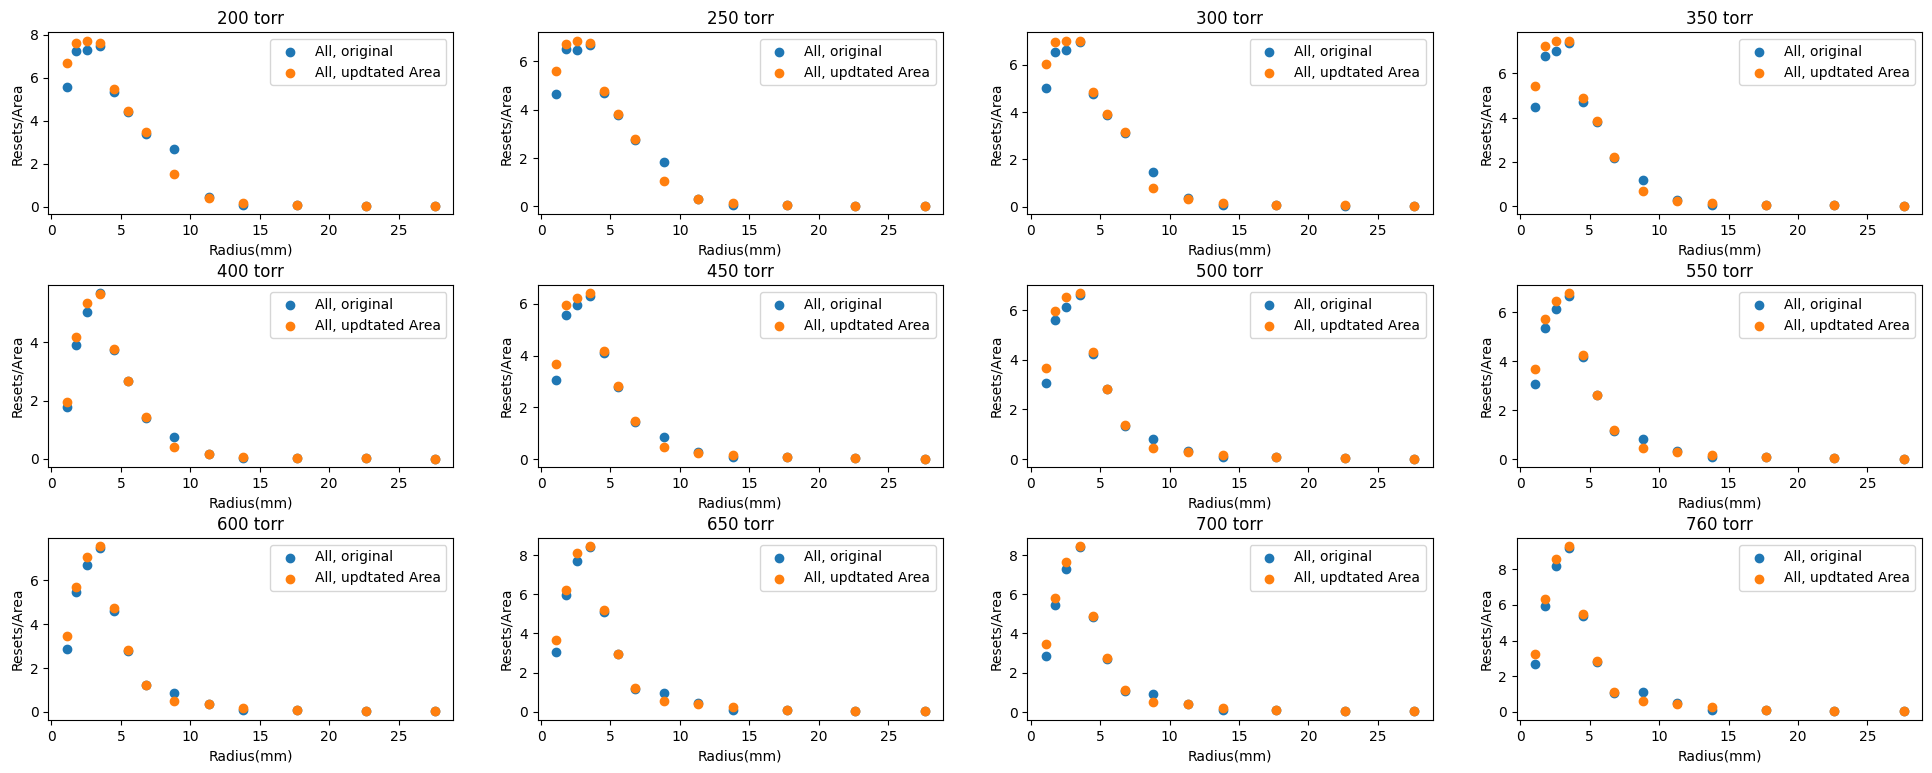

In [ ]:
#####################################################################################
# Resets/Area vs. Radius for comparison between:                                    #
# 1. original data from Nora
# 2. new csv data with updated area of each channel and excluding the min pid reset #
######################################################################################
fig, axes = plt.subplots(3, 4, figsize=(20, 8))
fig.tight_layout(pad=3.0)

pressures = [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 760]

for i, (df1, pressure) in enumerate(zip(data_frames_1, pressures)):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    ax.scatter(saq.radius_of_channel[1:-2], df1.iloc[:, 1], label= 'All, original')
    ax.set_xlabel('Radius(mm)')

    ax.set_ylabel('Resets/Area')
    ax.set_title(f'{pressure} torr')
    #ax.set_ylim(0, 8)


for i, (df2, pressure) in enumerate(zip(data_frames_2, pressures)):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    ax.scatter(saq.radius_of_channel[1:-2], df2.iloc[:, 1], label= 'All, updtated Area')
    ax.legend()

[10.12, 11.300158421917185, 12.204064364650781, 9.99038696592031, 12.345716525937823, 12.687779572009312, 11.301949184994832, 10.966634525166382, 9.270935446765147, 10.29288594005575, 10.11320253553837, 11.178515817568664, 11.120297291455861]


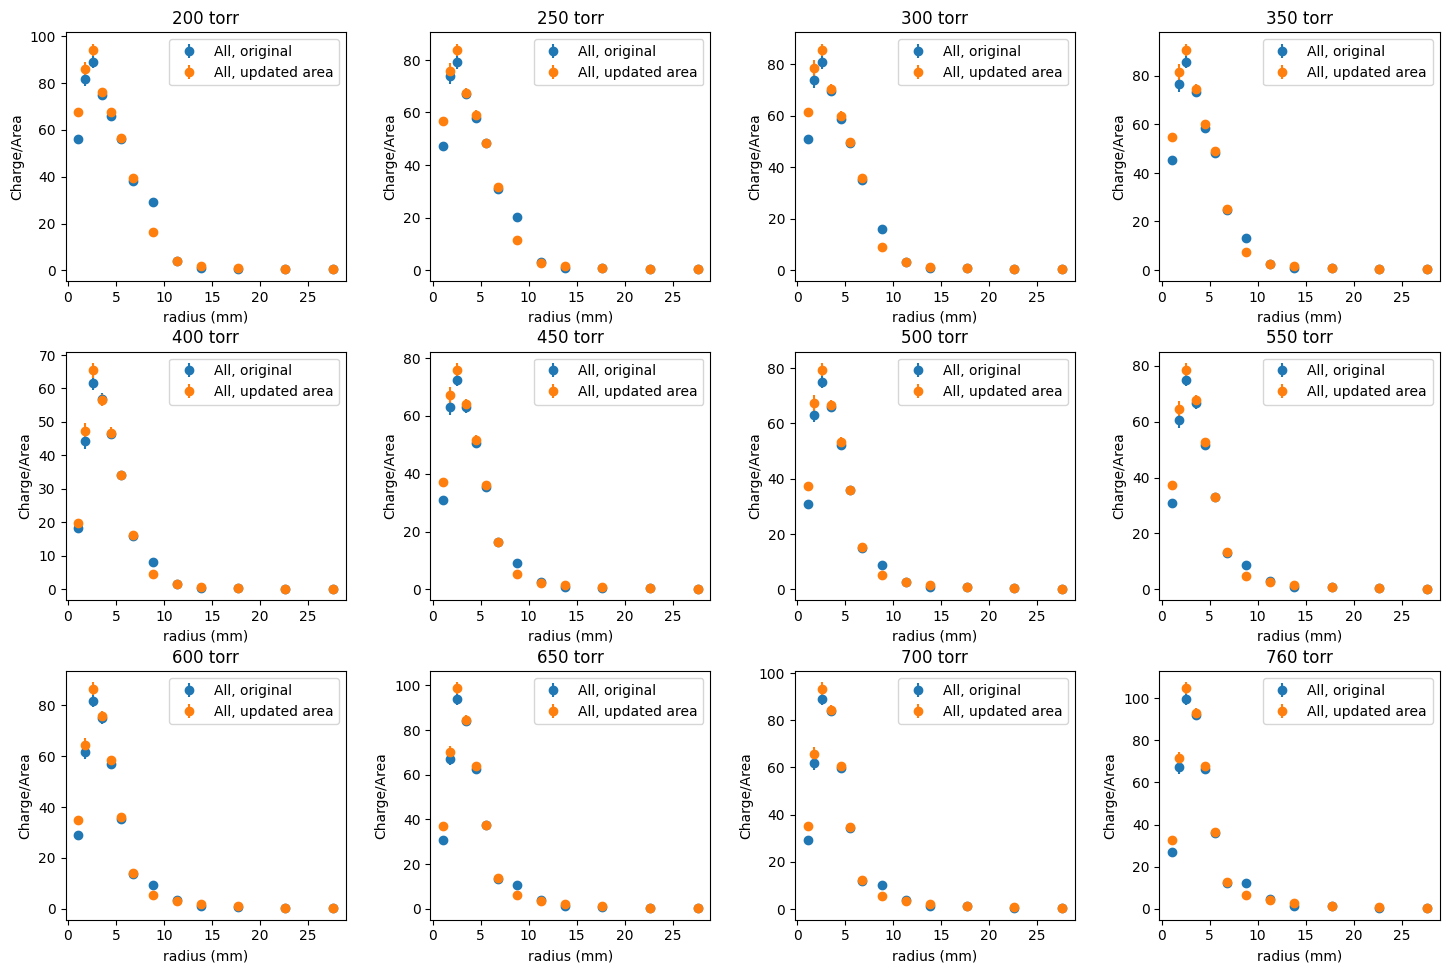

In [ ]:
##################################################################################
## Covert the resets/area in the cell above into Charge/Area with errors  ########
##################################################################################

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.tight_layout(pad=3.0)

pressures = [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 760]
x_ch = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

#Remove ch1, ch15 and ch16 from the mean_charge and std_charge
reduced_mean_charge = mean_charge[1:14]
reduced_std_charge = std_charge[1:14]
print(reduced_mean_charge)

for i, (df1, pressure) in enumerate(zip(data_frames_1, pressures)):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    ax.errorbar(saq.radius_of_channel[1:-2], df1.iloc[:, 1]*reduced_mean_charge, yerr=df1.iloc[:, 1]**(0.5)*reduced_std_charge, fmt='o', label= 'All, original') # charge/area vs. radius with errors

    ax.set_xlabel('radius (mm)')
    ax.set_ylabel('Charge/Area')
    ax.set_title(f'{pressure} torr')

for i, (df2, pressure) in enumerate(zip(data_frames_2, pressures)):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    ax.errorbar(saq.radius_of_channel[1:-2], df2.iloc[:, 1]*reduced_mean_charge, yerr=df2.iloc[:, 1]**(0.5)*reduced_std_charge, fmt='o', label= 'All, updated area') # charge/area vs. radius with errors
    #ax.errorbar(x_ch, df2.iloc[:, 1]*reduced_mean_charge, yerr=df2.iloc[:, 1]**(0.5)*reduced_std_charge, fmt='o', label= 'All, updated area') # charge/area vs. radius with errors

    ax.legend()

In [ ]:
print(saq.radius_of_channel)
print(saq.area)

[ 0.47376154  1.08855317  1.78272712  2.58085228  3.53032477  4.52659149
  5.52812179  6.78769423  8.82738345 11.31492477 13.81784241 17.68517098
 22.61571865 27.61034335 35.35336763 45.30267516]
[1.41026094e+00 4.62472598e+00 7.89871791e+00 1.39836216e+01
 2.24738983e+01 2.79602092e+01 3.53120952e+01 6.21568379e+01
 1.37962020e+02 1.76855874e+02 2.18389447e+02 5.47106749e+02
 7.01396462e+02 8.74805478e+02 2.18843298e+03 2.85364588e+03]


In [ ]:
#Use the function glob() in the glob libary to obtain a list of paths matching a pathname pattern and use sorted() to sort them
root_file_paths = sorted(glob.glob('/home/wwz/saq_analysis/calibration/pressure_scan/*.root'))
#sorted(root_file_paths)
print(root_file_paths)

['/home/wwz/saq_analysis/calibration/pressure_scan/05_19_2023_08_41_26.root', '/home/wwz/saq_analysis/calibration/pressure_scan/05_19_2023_09_31_24.root', '/home/wwz/saq_analysis/calibration/pressure_scan/05_19_2023_10_17_29.root', '/home/wwz/saq_analysis/calibration/pressure_scan/05_19_2023_11_03_17.root', '/home/wwz/saq_analysis/calibration/pressure_scan/05_19_2023_11_50_02.root', '/home/wwz/saq_analysis/calibration/pressure_scan/05_19_2023_12_36_24.root', '/home/wwz/saq_analysis/calibration/pressure_scan/05_19_2023_13_23_33.root', '/home/wwz/saq_analysis/calibration/pressure_scan/05_19_2023_14_10_43.root', '/home/wwz/saq_analysis/calibration/pressure_scan/05_19_2023_14_57_48.root', '/home/wwz/saq_analysis/calibration/pressure_scan/05_19_2023_15_45_23.root', '/home/wwz/saq_analysis/calibration/pressure_scan/05_19_2023_16_33_02.root', '/home/wwz/saq_analysis/calibration/pressure_scan/05_19_2023_17_21_28.root']


KeyboardInterrupt: 

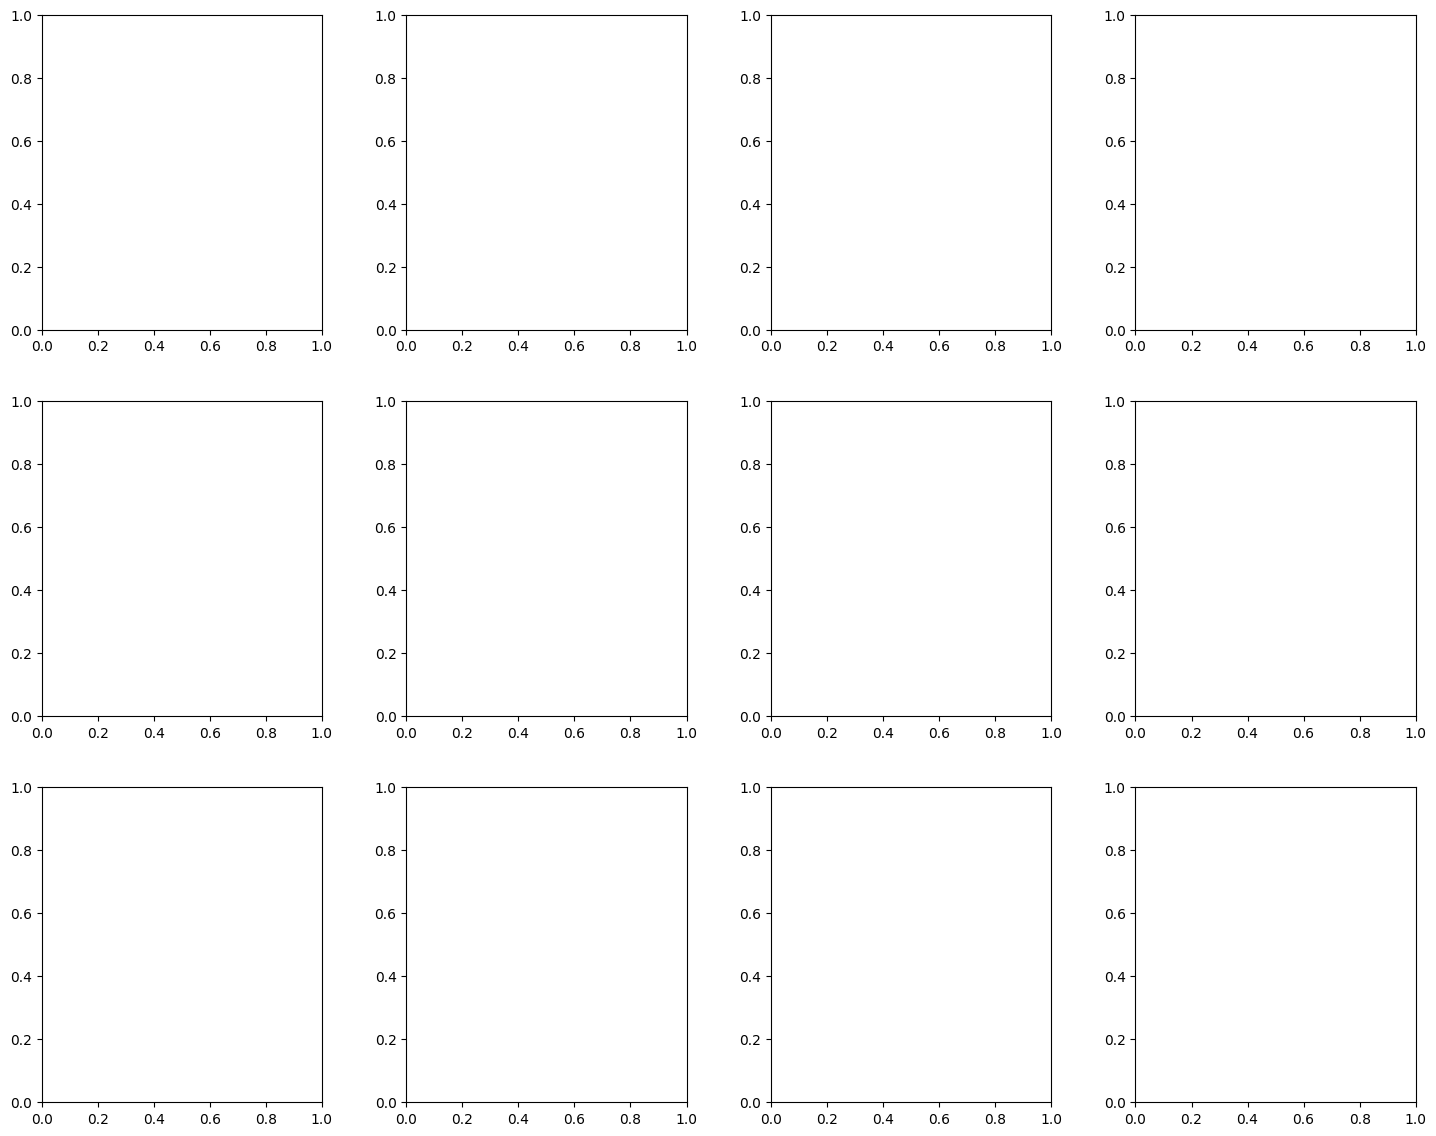

In [ ]:
#################################################################
# Diagnosis plot: reset counts vs. number of channels present  ##
#################################################################

fig, axes = plt.subplots(3, 4, figsize=(15, 12))
fig.tight_layout(pad=3.0)

pressures = [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 760]

# Iterate through each root file
for k, root_file_path in enumerate(root_file_paths):
    #root_file_path = '/home/wwz/saq_analysis/calibration/05_19_2023_15_45_23.root'
    file = uproot.open(root_file_path)

    # Access the tree from the ROOT file
    tree = file["tt"]  # 'tt' is the name of the data tree in the root file

    # Convert the tree data into a dictionary
    data = tree.arrays(library="np")
    # Get timestamps from the data
    timestamps = data["Timestamp"]
    mask = data["ChMask"]
    pid = data["pid"]
    #print(pid[:10])
    # #print(len(pid))
    filtered_pid = [pid[i] for i in range(len(timestamps)) if pid[i] != min(pid)]
    filtered_mask = [mask[i] for i in range(5, len(timestamps)) if mask[i] !=0]

    #print(len(pid), ", ", len(filtered_pid))
    
    resets_single = [] # store all single-channel resets for all channels
    resets_multi = [] # store all single-channel resets for all channels

    
    length_counts = {}
    
    for i in range(len(filtered_mask)):
        length = len(saq.channels_in_reset_mask(filtered_mask[i]))
        if length in length_counts:
            length_counts[length] += 1
        else:
            length_counts[length] = 1
        #print(length)
        #print(filtered_mask[i], ",", saq.channels_in_reset_mask(filtered_mask[i]))

    # Extracting lengths and counts for plotting
    lengths = list(length_counts.keys())
    counts = list(length_counts.values())

 
    row = k // 4
    col = k % 4
    ax = axes[row, col]

    # Plotting the counts as a function of length
    ax.bar(lengths, counts)
    ax.set_xlabel('Number of channels present')
    ax.set_ylabel('Counts')
    ax.set_yscale('log')
    ax.set_title(f'{pressures[k]} torr')
    




  

In [ ]:
print(saq.channels_in_reset_mask(4))

[2]


KeyboardInterrupt: 

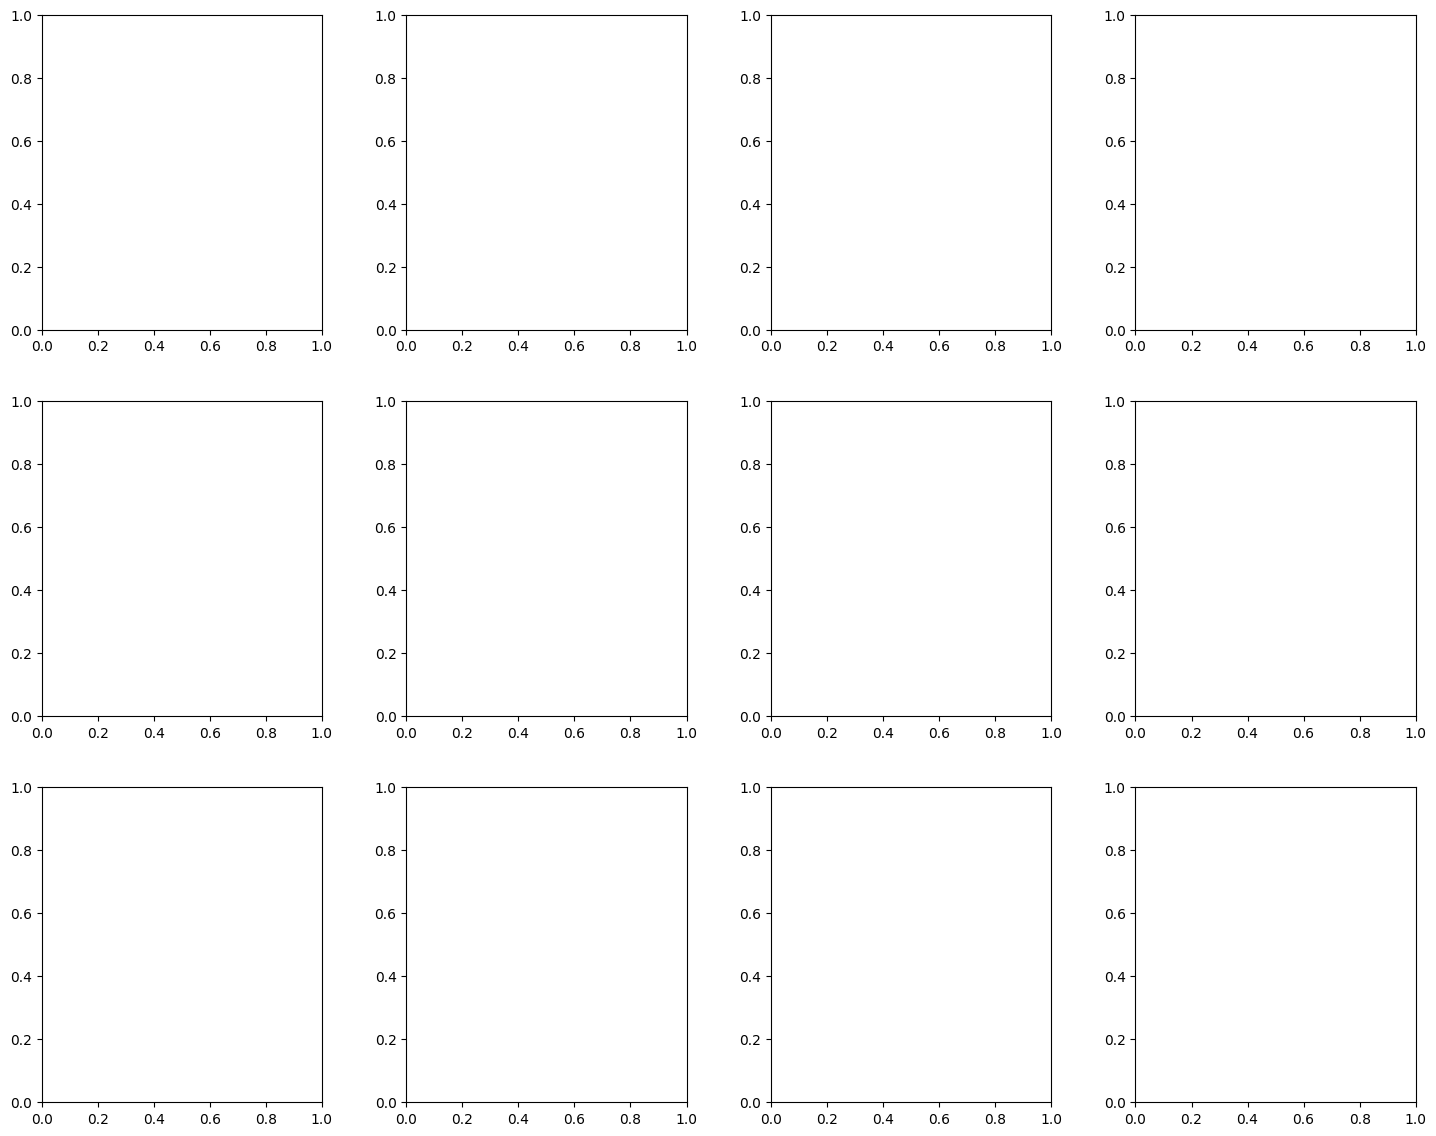

In [ ]:
##########################################################################
# Diagnosis plot: reset counts vs. channels for the following cases:    ##
# 1. Only one channel is present                                        ##
# 2. Two channels are present                                           ##
# 3. Three channels are present                                         ##
# 4. Four channels are present                                          ##
# 5. Five channels are present                                          ##
# 6. More than one channel are present                                  ##
##########################################################################
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
fig.tight_layout(pad=3.0)

pressures = [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 760]

# Iterate through each root file
for k, root_file_path in enumerate(root_file_paths):
    file = uproot.open(root_file_path)

    # Access the tree from the ROOT file
    tree = file["tt"]  # 'tt' is the name of the data tree in the root file

    # Convert the tree data into a dictionary
    data = tree.arrays(library="np")
    # Get timestamps from the data
    timestamps = data["Timestamp"]
    mask = data["ChMask"]
    pid = data["pid"]
    #print(pid[:10])
    # #print(len(pid))
    filtered_pid = [pid[i] for i in range(len(timestamps)) if pid[i] != min(pid)]
    filtered_mask = [mask[i] for i in range(len(timestamps)) if (pid[i] != min(pid) and mask[i] !=0)]

    #print(len(pid), ", ", len(filtered_pid))
    
    ch_resets_1 = [] # store one-channel resets for all channels
    ch_resets_2 = [] # store two-channel resets for all channels
    ch_resets_3 = [] # store three-channel resets for all channels
    ch_resets_4 = [] # store four-channel resets for all channels
    ch_resets_5 = [] # store five-channel resets for all channels
    ch_resets_multi = [] # store multi-channel resets for all channels
    
    for i in range(len(filtered_mask)):
        length = len(saq.channels_in_reset_mask(filtered_mask[i]))
        #print(length)
        if length == 1:
           # print(saq.channels_in_reset_mask(filtered_mask[i]))
            ch_resets_1.append(saq.channels_in_reset_mask(filtered_mask[i])[0])

        if length == 2:
            #print(saq.channels_in_reset_mask(filtered_mask[i]))
            for j in range(length):
                ch_resets_2.append(saq.channels_in_reset_mask(filtered_mask[i])[j])

        if length == 3:
            #print(saq.channels_in_reset_mask(filtered_mask[i]))
            for j in range(length):
                ch_resets_3.append(saq.channels_in_reset_mask(filtered_mask[i])[j])

        if length == 4:
            #print(saq.channels_in_reset_mask(filtered_mask[i]))
            for j in range(length):
                ch_resets_4.append(saq.channels_in_reset_mask(filtered_mask[i])[j])

        if length == 5:
            #print(saq.channels_in_reset_mask(filtered_mask[i]))
            for j in range(length):
                ch_resets_5.append(saq.channels_in_reset_mask(filtered_mask[i])[j])
        
        if length > 1:
            for j in range(length):
                ch_resets_multi.append(saq.channels_in_reset_mask(filtered_mask[i])[j])

    #print(ch_resets_1)

    # Initializing counts for numbers 0 to 15
    ch = [0] * 16 #ch_single[i] stores the number of single-channel resets in channel i. 
    
    for num in ch_resets_multi:
        ch[num] += 1
    #print (ch)
        
    row = k // 4
    col = k % 4
    ax = axes[row, col]

    x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

    # Plotting the counts as a function of length
    ax.bar(x, ch)
    #ax.bar(saq.radius_of_channel, ch)
    ax.set_xlabel('Channel')
    ax.set_ylabel('Counts')
    #ax.set_yscale('log')
    ax.set_title(f'{pressures[k]} torr')
